## Projeto 1 - SCC0275 - Introdução à Ciência de Dados

### Nome: Nilo Conrado Messias Alves Cangerana
### Número USP: 9805362

In [1]:
#imports
import platform
import pickle
import numpy as np
from itertools import product
from bitstring import BitArray, Bits, BitStream
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd

In [2]:
print("Versão Python utilizada: ",platform.python_version()) 

Versão Python utilizada:  3.7.9


### Código Auxiliar

In [3]:
class MyImgFormat:
    def __init__(self, mat_rgb_ids, rgb_ids_dict):
        self.im_shape_      = mat_rgb_ids.shape
        self.rgb_ids_dict_  = rgb_ids_dict
        self.num_bits_uint_ = int(np.ceil(np.log2(len(rgb_ids_dict))))
        
        self._mat2bytes(mat_rgb_ids)
        
    def _mat2bytes(self, mat):
        self.pixel_bytes_ = BitStream()
        
        pixel_rgb_ids = mat.reshape(-1)
        for rgb_id in pixel_rgb_ids:
            self.pixel_bytes_.append(Bits(uint=rgb_id, length=self.num_bits_uint_))
        
    def unpack(self):
        # unpack IDs
        cp_bits = self.pixel_bytes_.copy()
        num_ids = cp_bits.len // self.num_bits_uint_
        
        mat_ids = np.array([
            cp_bits.read('uint:%d' % (self.num_bits_uint_))\
            for i in range(num_ids)\
        ]).reshape(self.im_shape_)
        
        # unpack RGB
        im_rgb = np.zeros((self.im_shape_[0], self.im_shape_[1], 3), dtype='uint8')
        for i in range(self.im_shape_[0]):
            for j in range(self.im_shape_[1]):
                im_rgb[i, j, :] = self.rgb_ids_dict_[mat_ids[i, j]]
                
        return im_rgb

In [4]:
def uniform_quant(im, n_colors):
    # numero de cores e espaco entre as cores (lagura do bin)
    n_vals_ch  = int(np.cbrt(n_colors))
    bin_size   = 256 // n_vals_ch
    
    # possiveis valores por canal e por pixel (combinacao dos 3 canais)
    ch_vals    = np.uint8((np.arange(n_vals_ch)) * bin_size)
    pixel_vals = list(product(ch_vals, ch_vals, ch_vals))
    
    im_qt_rgb  = im // bin_size
    im_qt_rgb[im_qt_rgb >= n_vals_ch] = n_vals_ch - 1
    im_qt_rgb  = np.uint8((im_qt_rgb) * bin_size)
    
    # criar os dicionarios ID -> pixel e pixel -> ID
    dict_id2pixel = {i: list(pixel_vals[i]) for i in range(len(pixel_vals))}
    dict_pixel2id = {pixel_vals[i]: i for i in range(len(pixel_vals))}
    
    mat_ids = np.zeros((im.shape[0], im.shape[1]), dtype='uint8')
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            mat_ids[i, j] = dict_pixel2id[tuple(im_qt_rgb[i, j])]
    
    return mat_ids, dict_id2pixel

In [5]:
def get_bin_size_kb(obj):
    return len(pickle.dumps(obj)) / 1e3

## Questão 1

#### a)

In [6]:
def uniform_quant_mod(im, n_colors):
    # numero de cores e espaco entre as cores (lagura do bin)
    n_vals_ch  = int(np.cbrt(n_colors))
    bin_size   = 256 // n_vals_ch
    
    # possiveis valores por canal e por pixel (combinacao dos 3 canais)
    ch_vals    = np.uint8((np.arange(n_vals_ch)) * bin_size)
    vals_interval=np.uint8((ch_vals[1]-ch_vals[0])/2) #armazena o valor do intervalo dividido por 2
    pixel_vals = list(product(ch_vals, ch_vals, ch_vals))

    im_qt_rgb  = im // bin_size
    im_qt_rgb[im_qt_rgb >= n_vals_ch] = n_vals_ch - 1
    im_qt_rgb  = np.uint8((im_qt_rgb) * bin_size)
    
    # criar os dicionarios ID -> pixel e pixel -> ID
    #adiciona o valor de vals_interval a cada valor do dicionario que é criado
    dict_id2pixel = {i: [x+vals_interval for x in list(pixel_vals[i])] for i in range(len(pixel_vals))}
    dict_pixel2id = {pixel_vals[i]: i for i in range(len(pixel_vals))}
    
    mat_ids = np.zeros((im.shape[0], im.shape[1]), dtype='uint8')
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            mat_ids[i, j] = dict_pixel2id[tuple(im_qt_rgb[i, j])]
    
    return mat_ids, dict_id2pixel

#### b)

In [7]:
im_original = load_sample_image("china.jpg")

Imagem china.jpg original:


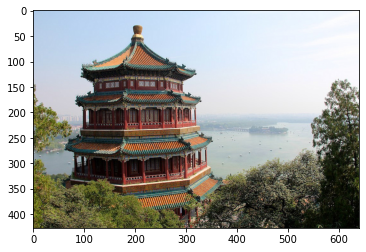

In [8]:
print("Imagem china.jpg original:")
plt.imshow(im_original)

In [9]:
mat_ids, dict_rgb = uniform_quant(im_original, 64)
im_qt_obj = MyImgFormat(mat_ids, dict_rgb)
im_qt = im_qt_obj.unpack()

Imagem china.jpg quantizada para 64 cores usando o código original:


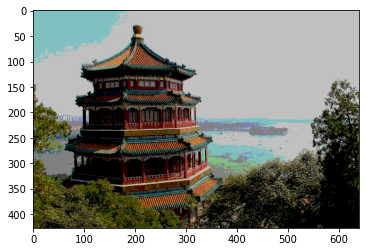

In [10]:
print("Imagem china.jpg quantizada para 64 cores usando o código original:")
plt.imshow(im_qt)

In [11]:
mat_ids_mod, dict_rgb_mod = uniform_quant_mod(im_original, 64)
im_qtmod_obj = MyImgFormat(mat_ids_mod, dict_rgb_mod)
im_qtmod = im_qtmod_obj.unpack()

Imagem china.jpg quantizada para 64 cores usando o código modificado:


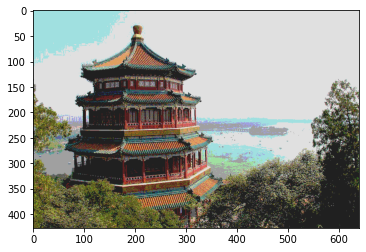

In [12]:
print("Imagem china.jpg quantizada para 64 cores usando o código modificado:")
plt.imshow(im_qtmod)

#### c)

In [13]:
#Tamanho da imagem original:
get_bin_size_kb(im_original)

820.002

In [14]:
#Tamanho da imagem para 64 cores com o código original:
get_bin_size_kb(im_qt_obj)

206.334

In [15]:
#Tamanho da imagem para 64 cores com o código modificado:
get_bin_size_kb(im_qtmod_obj)

208.821

Como pode ser observado nos resultados, o tamanho em kb da imagem original é muito superior ao tamanho das imagens quantizadas(aproximadamente 4 vezes maior). A redução do tamanho garante que o armazenamento de imagens quantizadas seja mais compacto em relação ao armazenamento de imagens originais, aumentando a capacidade de armazenamento.

## Questão 2

#### a)

In [16]:
#Implementaçao do K-Means
def kmeansMethod(image, n_colors):
    X_image = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=n_colors, max_iter=10, random_state=42)
    kmeans.fit(X_image)
    clusters = kmeans.predict(X_image)
    mat_ids = clusters.reshape(image.shape[0], image.shape[1])
    dict_id2pixel = {i: list(np.uint16(kmeans.cluster_centers_[i])) for i in range(len(kmeans.cluster_centers_))}
    return mat_ids, dict_id2pixel

#### b)

In [17]:
#Rodar o método criado
mat_ids_kmeans, dict_rgb_kmeans = kmeansMethod(im_original, 64)

In [18]:
im_kmeans_obj = MyImgFormat(mat_ids_kmeans, dict_rgb_kmeans)
im_kmeans = im_kmeans_obj.unpack()

Imagem china.jpg quantizada para 64 cores usando o K-Means:


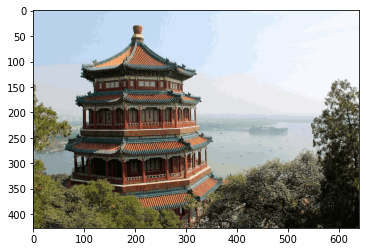

In [19]:
print("Imagem china.jpg quantizada para 64 cores usando o K-Means:")
plt.imshow(im_kmeans)

In [20]:
#Tamanho da imagem K-Means:
get_bin_size_kb(im_kmeans_obj)

210.141

Observando a imagem gerada pelo K-Means, e as imagens geradas pelos métodos de quantização utilizados anteriormente, pode-se concluir que o K-Means gera imagens mais próximas da imagem original, garantindo maior suavização nas transições de cores entre cada pixel. Além disso, o tamanho em kb da imagem gerada pelo K-Means possui o mesmo tamanho, aproximadamente, das imagens geradas pelos métodos de quantização. Assim, a imagem gerada pelo K-Means pode ser armazenada com uma qualidade muito maior e pelo mesmo tamanho das imagens quantizadas.

## Questão 3

#### a)

In [21]:
#Implementaçao do K-Means + inercia
def kmeansMethod_inercia(image, K_range):
    mat_ids_list=[]
    dict_id2pixel_list=[]
    inertia_list=[]
    X_image = image.reshape(-1, 3)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, max_iter=10, random_state=42)
        kmeans.fit(X_image)
        inertia_list.append(kmeans.inertia_)
        clusters = kmeans.predict(X_image)
        mat_ids = clusters.reshape(image.shape[0], image.shape[1])
        dict_id2pixel = {i: list(np.uint16(kmeans.cluster_centers_[i])) for i in range(len(kmeans.cluster_centers_))}
        mat_ids_list.append(mat_ids)
        dict_id2pixel_list.append(dict_id2pixel)
    return mat_ids_list, dict_id2pixel_list, inertia_list

In [22]:
#implementação do plot
def plotElbowMethod(k_values, inertiaList):
    plt.plot(k_values, inertiaList, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('Método Elbow para k ótimo.')
    plt.show()

#### b)

In [23]:
#Implementaçao do MSE
def calcularMSE(im_original, im_qt):
    im_dif = np.int16(im_original) - np.int16(im_qt)
    im_sq = im_dif**2
    im_soma = np.sum(im_sq)
    return im_soma/(im_original.shape[0]*im_original.shape[1]*im_original.shape[2])

## Questão 4

#### a)

In [24]:
im_original_flower = load_sample_image("flower.jpg")
k_values=[8, 27, 64, 125, 216]

In [25]:
#quantização uniforme china.jpg
mat_ids_china_qt_list=[]
dict_rgb_china_qt_list=[]

for k in k_values:
    matId, dictRGB = uniform_quant_mod(im_original, k)
    mat_ids_china_qt_list.append(matId)
    dict_rgb_china_qt_list.append(dictRGB)

In [26]:
obj_qt_china_list=[]
im_qt_china_list=[]
for i in range(len(k_values)):
    obj = MyImgFormat(mat_ids_china_qt_list[i], dict_rgb_china_qt_list[i])
    obj_qt_china_list.append(obj)
    im_qt_china_list.append(obj.unpack())

In [27]:
#quantização K-Means china.jpg
mat_ids_china_kmeans_list=[]
dict_rgb_china_kmeans_list=[]
inertia_china_kmeans_list=[]

mat_ids_china_kmeans_list, dict_rgb_china_kmeans_list, inertia_china_kmeans_list = kmeansMethod_inercia(im_original, k_values)

In [28]:
obj_kmeans_china_list=[]
im_kmeans_china_list=[]
for i in range(len(k_values)):
    obj = MyImgFormat(mat_ids_china_kmeans_list[i], dict_rgb_china_kmeans_list[i])
    obj_kmeans_china_list.append(obj)
    im_kmeans_china_list.append(obj.unpack())

In [29]:
#quantização uniforme flower.jpg
mat_ids_flower_qt_list=[]
dict_rgb_flower_qt_list=[]

for k in k_values:
    matId, dictRGB = uniform_quant_mod(im_original_flower, k)
    mat_ids_flower_qt_list.append(matId)
    dict_rgb_flower_qt_list.append(dictRGB)

In [30]:
obj_qt_flower_list=[]
im_qt_flower_list=[]
for i in range(len(k_values)):
    obj = MyImgFormat(mat_ids_flower_qt_list[i], dict_rgb_flower_qt_list[i])
    obj_qt_flower_list.append(obj)
    im_qt_flower_list.append(obj.unpack())

In [31]:
#quantização K-Means flower.jpg
mat_ids_flower_kmeans_list=[]
dict_rgb_flower_kmeans_list=[]
inertia_flower_kmeans_list=[]

mat_ids_flower_kmeans_list, dict_rgb_flower_kmeans_list, inertia_flower_kmeans_list = kmeansMethod_inercia(im_original_flower, k_values)

In [32]:
obj_kmeans_flower_list=[]
im_kmeans_flower_list=[]
for i in range(len(k_values)):
    obj = MyImgFormat(mat_ids_flower_kmeans_list[i], dict_rgb_flower_kmeans_list[i])
    obj_kmeans_flower_list.append(obj)
    im_kmeans_flower_list.append(obj.unpack())

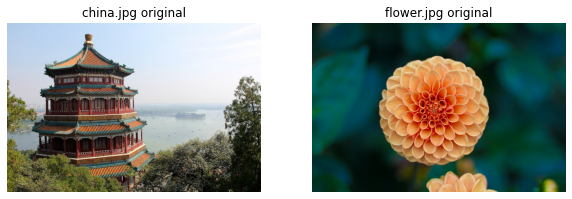

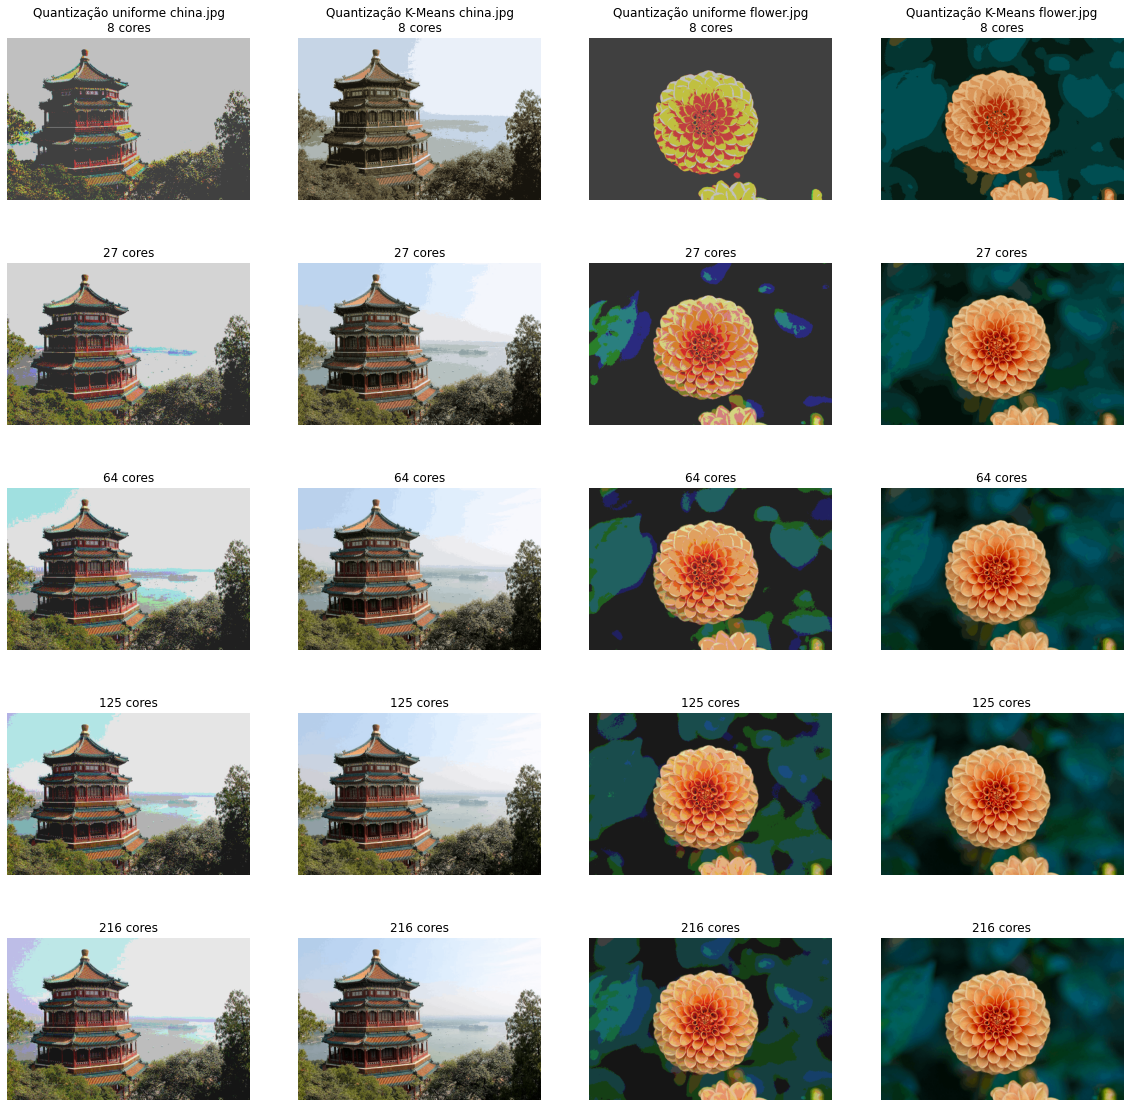

In [33]:
#Plot de imagens
plt.figure(figsize=(10, 10))
plt.subplot(1,2, 1).title.set_text('china.jpg original')
plt.axis('off')
plt.imshow(im_original)
plt.subplot(1,2, 2).title.set_text('flower.jpg original')
plt.axis('off')
plt.imshow(im_original_flower)
plt.show()

#Plotar imagens quantizadas
plt.figure(figsize=(20, 20))
plt.subplot(5,4, 1).title.set_text('Quantização uniforme china.jpg\n8 cores')
plt.axis('off')
plt.imshow(im_qt_china_list[0])
plt.subplot(5,4, 5).title.set_text('27 cores')
plt.axis('off')
plt.imshow(im_qt_china_list[1])
plt.subplot(5,4, 9).title.set_text('64 cores')
plt.axis('off')
plt.imshow(im_qt_china_list[2])
plt.subplot(5,4, 13).title.set_text('125 cores')
plt.axis('off')
plt.imshow(im_qt_china_list[3])
plt.subplot(5,4, 17).title.set_text('216 cores')
plt.axis('off')
plt.imshow(im_qt_china_list[4])

###quantizacao kmeans china.jpg
plt.subplot(5,4, 2).title.set_text('Quantização K-Means china.jpg\n8 cores')
plt.axis('off')
plt.imshow(im_kmeans_china_list[0])
plt.subplot(5,4, 6).title.set_text('27 cores')
plt.axis('off')
plt.imshow(im_kmeans_china_list[1])
plt.subplot(5,4, 10).title.set_text('64 cores')
plt.axis('off')
plt.imshow(im_kmeans_china_list[2])
plt.subplot(5,4, 14).title.set_text('125 cores')
plt.axis('off')
plt.imshow(im_kmeans_china_list[3])
plt.subplot(5,4, 18).title.set_text('216 cores')
plt.axis('off')
plt.imshow(im_kmeans_china_list[4])

###quantizacao uniforme flower.jpg
plt.subplot(5,4, 3).title.set_text('Quantização uniforme flower.jpg\n8 cores')
plt.axis('off')
plt.imshow(im_qt_flower_list[0])
plt.subplot(5,4, 7).title.set_text('27 cores')
plt.axis('off')
plt.imshow(im_qt_flower_list[1])
plt.subplot(5,4, 11).title.set_text('64 cores')
plt.axis('off')
plt.imshow(im_qt_flower_list[2])
plt.subplot(5,4, 15).title.set_text('125 cores')
plt.axis('off')
plt.imshow(im_qt_flower_list[3])
plt.subplot(5,4, 19).title.set_text('216 cores')
plt.axis('off')
plt.imshow(im_qt_flower_list[4])

###quantizacao kmeans flower.jpg
plt.subplot(5,4, 4).title.set_text('Quantização K-Means flower.jpg\n8 cores')
plt.axis('off')
plt.imshow(im_kmeans_flower_list[0])
plt.subplot(5,4, 8).title.set_text('27 cores')
plt.axis('off')
plt.imshow(im_kmeans_flower_list[1])
plt.subplot(5,4, 12).title.set_text('64 cores')
plt.axis('off')
plt.imshow(im_kmeans_flower_list[2])
plt.subplot(5,4, 16).title.set_text('125 cores')
plt.axis('off')
plt.imshow(im_kmeans_flower_list[3])
plt.subplot(5,4, 20).title.set_text('216 cores')
plt.axis('off')
plt.imshow(im_kmeans_flower_list[4])

plt.show()

#### b)

Gráfico: Imagem china.jpg


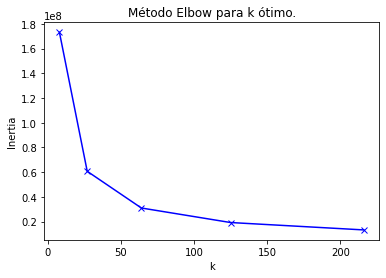

In [34]:
print("Gráfico: Imagem china.jpg")
plotElbowMethod(k_values, inertia_china_kmeans_list)

Gráfico: Imagem flower.jpg


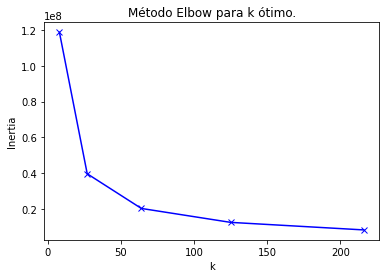

In [35]:
print("Gráfico: Imagem flower.jpg")
plotElbowMethod(k_values, inertia_flower_kmeans_list)

Observando os gráficos obtidos e de acordo com o método fornecido no enunciado da questão, pode-se concluir que o k ótimo consiste no valor de 64.

#### c)

In [36]:
#calcular MSE de cada imagem
mse_qt_china=[]
mse_kmeans_china=[]
mse_qt_flower=[]
mse_kmeans_flower=[]

for i in range(len(im_qt_china_list)):
    mse_qt_china.append(calcularMSE(im_original, im_qt_china_list[i]))
    mse_kmeans_china.append(calcularMSE(im_original, im_kmeans_china_list[i]))
    mse_qt_flower.append(calcularMSE(im_original_flower, im_qt_flower_list[i]))
    mse_kmeans_flower.append(calcularMSE(im_original_flower, im_kmeans_flower_list[i]))

In [37]:
mse_df = pd.DataFrame({'Qt Uniforme china.jpg': mse_qt_china, 
                       'Qt K-Means china.jpg': mse_kmeans_china,
                       'Qt Uniforme flower.jpg': mse_qt_flower,
                       'Qt K-Means flower.jpg': mse_kmeans_flower},
                       index=k_values)

In [38]:
print("Valores de MSE calculados para cada caso:")
mse_df

Valores de MSE calculados para cada caso:


,Qt Uniforme china.jpg,Qt K-Means china.jpg,Qt Uniforme flower.jpg,Qt K-Means flower.jpg
8,1531.375900,211.481348,1579.571971,145.053656
27,639.561384,74.381742,782.837390,48.791362
64,364.192137,38.242819,451.663697,25.273429
125,235.072237,23.815824,283.088960,15.779118
216,169.432199,16.575051,191.114314,10.652096


Como pode ser observado na tabela, o valor do MSE reduz conforme se aumenta a quantidade de cores na imagem quantizada. Isso ocorre pois com uma maior quantidade de cores, a representação da imagem quantizada fica mais próxima da original, ocasionando redução no MSE. Além disso, é possível observar que o MSE do K-Means é muito menor em relação ao MSE da quantização uniforme, ou seja, o K-Means representa a imagem mais próxima da original do que a quantização uniforme. Portanto, o K-Means possui o melhor MSE.

Comparando as imagens, pode-se concluir que com mais cores, maior a qualidade de representação visual e, com mais cores, o MSE é menor, pois a imagem está mais próxima da original.

#### d)

In [39]:
#calcular tamanho de cada imagem
tam_qt_china=[]
tam_kmeans_china=[]
tam_qt_flower=[]
tam_kmeans_flower=[]

for i in range(len(im_qt_china_list)):
    tam_qt_china.append(get_bin_size_kb(obj_qt_china_list[i]))
    tam_kmeans_china.append(get_bin_size_kb(obj_kmeans_china_list[i]))
    tam_qt_flower.append(get_bin_size_kb(obj_qt_flower_list[i]))
    tam_kmeans_flower.append(get_bin_size_kb(obj_kmeans_flower_list[i]))

In [40]:
tam_df = pd.DataFrame({'Qt Uniforme china.jpg': tam_qt_china, 
                       'Qt K-Means china.jpg': tam_kmeans_china,
                       'Qt Uniforme flower.jpg': tam_qt_flower,
                       'Qt K-Means flower.jpg': tam_kmeans_flower},
                       index=k_values)

In [41]:
print("Tamanho(kb) para cada caso:")
print("china.jpg original: ", get_bin_size_kb(im_original))
print("flower.jpg original: ", get_bin_size_kb(im_original_flower))
tam_df

Tamanho(kb) para cada caso:
china.jpg original:  820.002
flower.jpg original:  820.002


,Qt Uniforme china.jpg,Qt K-Means china.jpg,Qt Uniforme flower.jpg,Qt K-Means flower.jpg
8,103.240,103.330,103.240,103.330
27,172.380,172.836,172.380,172.836
64,208.821,210.141,208.821,210.141
125,246.891,249.486,246.891,249.486
216,286.881,291.381,286.881,291.381


Conforme pode ser observado na tabela, o tamanho das imagens quantizadas é muito menor que o tamanho das imagens originais, isso garante maior capacidade de armazenamento para imagens quantizadas. Além disso, pode ser observado que ao aumentar a quantidade de cores, o tamanho também aumenta devido a maior quantidade de dados presentes nas estruturas.